In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import numpy as np
import pandas as pd
import rasterio as rio
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import pickle

In [2]:
data_dir = '/bsuscratch/zacharykeskinen/data/uavsar/images'
fig_dir = expanduser('~/uavsar/figures/coherence_collections/')
pol_cols = {'VV':'red', 'VH':'green','HV':'aqua','HH':'blue'}
np.random.seed(20220503)

## Scene Wide Coherence - First we can investigate scene wide coherence vs temporal baseline with subsets for two different peg headings and polarizations

In [12]:
res = pd.DataFrame()

for dir in glob(join(data_dir, '*')):
    pairs = glob(join(dir, '*'))
    pairs = [pair for pair in pairs if basename(pair) != 'tmp']
    for pair in tqdm(pairs):
        coh_fps = glob(join(pair, '*cor.grd.tiff'))
        for coh_fp in coh_fps:
            dic = {}
            desc = pd.read_csv(glob(join(pair, '*.csv'))[0], index_col = 0)
            dic['first_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 1'])
            dic['second_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 2'])
            dic['heading'] = desc.loc['value', 'peg heading']
            dic['pol'] = basename(coh_fp).split('_')[6][4:]
            with rio.open(coh_fp) as src:
                arr = src.read(1)
                dic['coh_25'], dic['coh_75'] = np.nanquantile(arr, [0.25, 0.75])
                dic['median_coh'] = np.nanmedian(arr)
            res = pd.concat([res, pd.DataFrame.from_records([dic])])
res['diff_dt'] = (res['second_dt'] - res['first_dt']).astype('timedelta64[D]')
with open(expanduser('~/uavsar/results/time_coh/res_df'), 'wb') as f:
    pickle.dump(res, f)

  0%|          | 0/17 [00:09<?, ?it/s]


KeyboardInterrupt: 

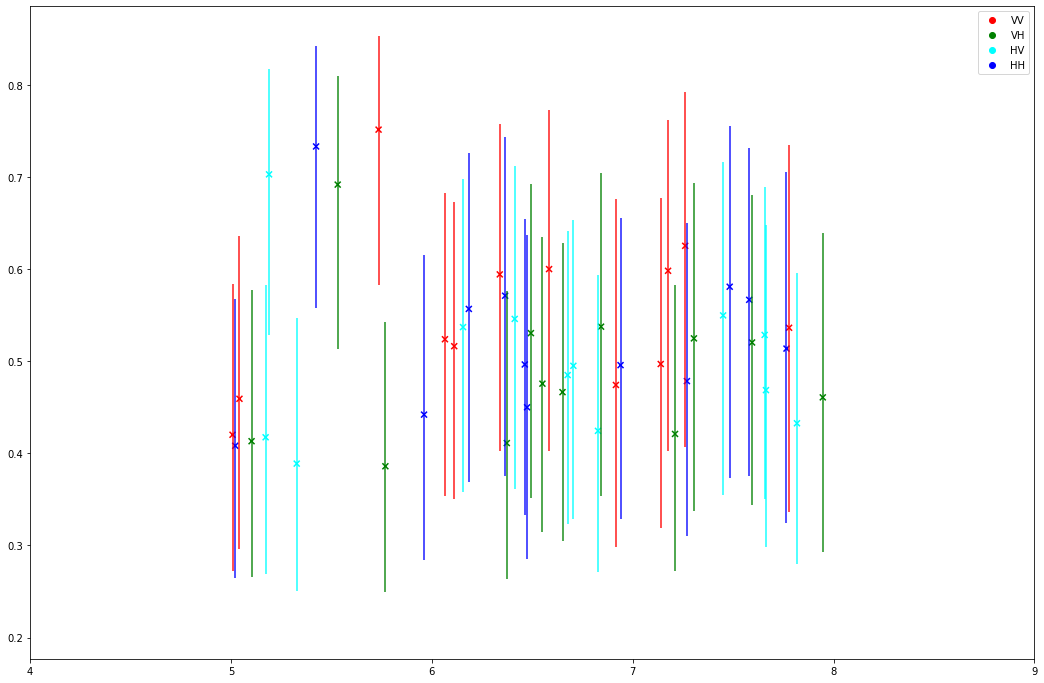

In [11]:
with open(expanduser('~/uavsar/results/time_coh/res_df'), 'rb') as f:
    res = pickle.load(f)
pol_cs = [pol_cols[i] for i in res.pol]
plt.figure(figsize = (18,12))
jitter = np.random.random(len(res.diff_dt))
plt.vlines(x = res.diff_dt + jitter, ymin = res['coh_25'], ymax = res['coh_75'], colors = pol_cs, alpha = 0.9)
plt.scatter(x = res.diff_dt + jitter, y = res.median_coh, marker = 'x', c = pol_cs)
# plt.xscale('log')

# The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.xlim(4,9)
plt.savefig(join(fig_dir, 'temp_pol_coh.png'), dpi = 300)

## Compare sd change from snotels to windowed coherence aroundthe snotel

In [3]:
from meso_extract import meso_notebook_extract

In [28]:
res = pd.DataFrame()
cols = ['Lowman, CO']
for b_side in [5,10,25]:
    for col in cols:
        pairs = glob(join(data_dir, col, '*'))
        pairs = [pair for pair in pairs if basename(pair) != 'tmp']
        for pair in tqdm(pairs):
            coh_fps = glob(join(pair, '*cor.grd.tiff'))
            for coh_fp in coh_fps:
                dic = {}
                csv_fp = glob(join(pair, '*.csv'))[0]
                desc = pd.read_csv(csv_fp, index_col = 0)
                dic['first_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 1'])
                dic['second_dt'] = pd.to_datetime(desc.loc['value', 'start time of acquisition for pass 2'])
                dic['heading'] = desc.loc['value', 'peg heading']
                dic['pol'] = basename(coh_fp).split('_')[6][4:]
                dic['meso_result'] = meso_notebook_extract(img_fp=coh_fp, ann_csv = csv_fp, col_in = 'snow_depth_set_1', box_side=b_side)
                res = pd.concat([res, pd.DataFrame.from_records([dic])])
    res['diff_dt'] = (res['second_dt'] - res['first_dt']).astype('timedelta64[D]')
    with open(expanduser(f'~/uavsar/results/coh_snotel_sd/res_df_{b_side}'), 'wb') as f:
        pickle.dump(res, f)

 12%|█▏        | 2/17 [02:18<17:08, 68.58s/it]

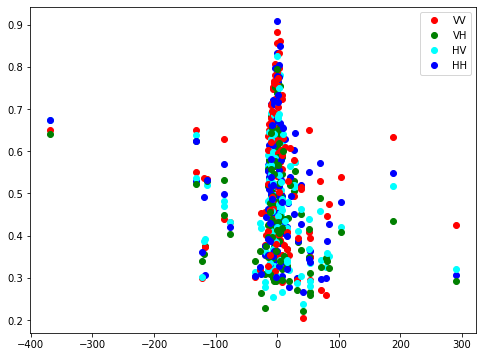

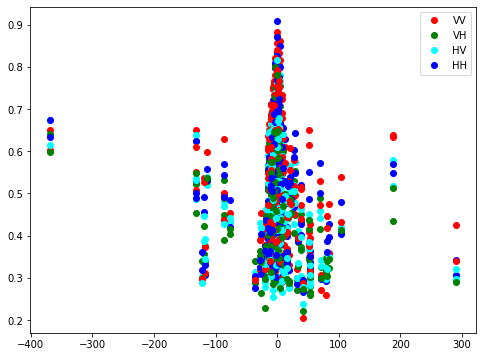

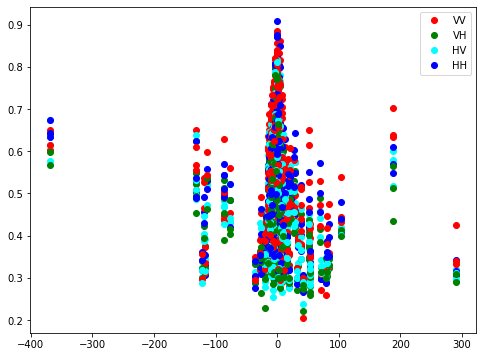

In [9]:
for b_side in [5,10,25]:
    plt.figure(figsize = (8,6))
    with open(expanduser(f'~/uavsar/results/coh_snotel_sd/res_df_{b_side}'), 'rb') as f:
        res = pickle.load(f)
    for i,r in res.iterrows():
        for stat in r.meso_result:
            # d_sd = r.meso_result[stat]['delta_sd']
            d_sd = r.meso_result[stat]['delta_{col_name}'] * 100
            coh = r.meso_result[stat]['img_arr_mean']
            plt.scatter(d_sd, coh, c = pol_cols[r.pol])
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
    plt.legend(markers, pol_cols.keys(), numpoints=1)
    plt.show()